# Data Preparation Term Project
## Joshua Greenert
## DSC540-T301 Data Preparation
## 11/10/2022

## Prepare Flat File Data

In [1]:
# Optional suggestions 
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Read the data into a dataframe.
df_companies_flat = pd.read_csv('Fortune 1000 Companies by Revenue.csv')

# Fix column names to not have any spaces.
df_companies_flat.set_axis(["rank", "name", "revenues", "revenue_percent_change", "profits", "profits_percent_change", "assets", "market_value", "change_in_rank", "employees" ], axis=1, inplace=True)

# Reduce all names to lowercase.
df_companies_flat['name'] = df_companies_flat['name'].str.lower()

# Strip the white spaces from the columns
df_obj = df_companies_flat.select_dtypes(['object'])
df_companies_flat[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())

# Remove the dollar signs from all values.
df_companies_flat["revenues"] = df_companies_flat['revenues'].str.replace('$','')
df_companies_flat["profits"] = df_companies_flat['profits'].str.replace('$','')
df_companies_flat["assets"] = df_companies_flat['assets'].str.replace('$','')
df_companies_flat["market_value"] = df_companies_flat['market_value'].str.replace('$','')
df_companies_flat["employees"] = df_companies_flat['employees'].str.replace('$','')

# Remove the commas from all values.
df_companies_flat["rank"] = df_companies_flat['rank'].str.replace(',','')
df_companies_flat["revenues"] = df_companies_flat['revenues'].str.replace(',','')
df_companies_flat["profits"] = df_companies_flat['profits'].str.replace(',','')
df_companies_flat["assets"] = df_companies_flat['assets'].str.replace(',','')
df_companies_flat["market_value"] = df_companies_flat['market_value'].str.replace(',','')
df_companies_flat["employees"] = df_companies_flat['employees'].str.replace(',','')

# Replace opening parenthesis with negative sign (-)
df_companies_flat["revenues"] = df_companies_flat['revenues'].str.replace('(','-')
df_companies_flat["profits"] = df_companies_flat['profits'].str.replace('(','-')
df_companies_flat["assets"] = df_companies_flat['assets'].str.replace('(','-')
df_companies_flat["market_value"] = df_companies_flat['market_value'].str.replace('(','-')
df_companies_flat["employees"] = df_companies_flat['employees'].str.replace('(','-')

# Replace ending parenthesis altogether.
df_companies_flat["revenues"] = df_companies_flat['revenues'].str.replace(')','')
df_companies_flat["profits"] = df_companies_flat['profits'].str.replace(')','')
df_companies_flat["assets"] = df_companies_flat['assets'].str.replace(')','')
df_companies_flat["market_value"] = df_companies_flat['market_value'].str.replace(')','')
df_companies_flat["employees"] = df_companies_flat['employees'].str.replace(')','')

# Drop all values that don't have profits or market value listed.
df_companies_flat = df_companies_flat.loc[df_companies_flat["profits"] != "-"]
df_companies_flat = df_companies_flat.loc[df_companies_flat["market_value"] != "-"]

# Update all numeric values to be numbers instead of strings.
df_companies_flat["revenues"] = pd.to_numeric(df_companies_flat['revenues'])
df_companies_flat["profits"] = pd.to_numeric(df_companies_flat['profits'])
df_companies_flat["assets"] = pd.to_numeric(df_companies_flat['assets'])
df_companies_flat["market_value"] = pd.to_numeric(df_companies_flat['market_value'])
df_companies_flat["employees"] = pd.to_numeric(df_companies_flat['employees'])

# Remove the change in rank column.
df_companies_flat = df_companies_flat.drop('change_in_rank', axis = 1)
df_companies_flat.head(5)

,rank,name,revenues,revenue_percent_change,profits,profits_percent_change,assets,market_value,employees
0,1,walmart,572754.0,2.40%,13673.0,1.20%,244860.0,409795.0,2300000
1,2,amazon,469822.0,21.70%,33364.0,56.40%,420549.0,1658807.3,1608000
2,3,apple,365817.0,33.30%,94680.0,64.90%,351002.0,2849537.6,154000
3,4,cvs health,292111.0,8.70%,7910.0,10.20%,232999.0,132839.2,258000
4,5,unitedhealth group,287597.0,11.80%,17285.0,12.20%,212206.0,479830.3,350000


## Prepare Website Data

In [2]:
import numpy as np
import requests
from bs4 import BeautifulSoup
import re

# Get the content from the page
page = requests.get("https://en.wikipedia.org/wiki/List_of_largest_companies_by_revenue")
content = page.content

# Create the page parser
soup = BeautifulSoup(content, 'html.parser')

# Get the countries table.
companies_table = soup.find('table', class_='wikitable sortable')

# Set up the dataframe to prepare for the data.
df_companies_website = pd.DataFrame(columns=['rank', 'name', 'industry', 'revenue', 
                                     'profit', 'employees', 'headquarters'])

# Create a count variable for the rank.
count = 1

# Collect the data and store them into the dataframe.
for row in companies_table.tbody.find_all('tr'):    
    # Find all data for each column
    columns = row.find_all('td')
    
    if(columns != []):
        
        # Skip rows where data is missing for any field.
        if(len(columns) != 7):
            continue
        else:
            Rank = count
            Name = columns[0].text.strip()
            Industry = columns[1].text.strip()
            Revenue = columns[2].text.strip()
            Profit = columns[3].text.strip()
            Employees = columns[4].text.strip()
            Headquarters = columns[5].text.strip()
            
            new_row = {'rank': Rank,  'name': Name, 'industry': Industry, 
                                                'revenue': Revenue, 'profit': Profit, 'employees': Employees, 
                                                'headquarters': Headquarters}
            df_companies_website.loc[len(df_companies_website.index)] = new_row
            
            # Update the counter for the rank
            count = count +1
            
# Convert all of the names to lowercase for each company.
df_companies_website['name'] = df_companies_website['name'].str.lower()

# Convert all categorical variables to lowercase as well to produce similar dummies in the future.
df_companies_website['industry'] = df_companies_website['industry'].str.lower()
df_companies_website['headquarters'] = df_companies_website['headquarters'].str.lower()

# Remove all punctuation from the revenue and profit values while converting them to floats.
# Loop through the records and update the values to remove punctuation and set as floats.
for i, row in df_companies_website.iterrows():
    profit_value = row["profit"]
    revenue_value = row["revenue"]
    
    # Remove all dollar and commas
    profit_value = profit_value.replace("$", "")
    profit_value = profit_value.replace(",", "")
    profit_value = profit_value.replace("–", "-")
    revenue_value = revenue_value.replace("$", "")
    revenue_value = revenue_value.replace(",", "")
    
    df_companies_website.at[i,'profit'] = profit_value
    df_companies_website.at[i,'revenue'] = float(revenue_value)
    
# Remove all commas from the employees values as well.
for i, row in df_companies_website.iterrows():
    employee_value = row["employees"]
    
    employee_value = employee_value.replace(",", "")
    
    df_companies_website.at[i,'employees'] = employee_value

df_companies_website.head(5)

,rank,name,industry,revenue,profit,employees,headquarters
0,1,walmart,retail,572754.0,13673,2300000,united states
1,2,amazon,retail,469822.0,33364,1608000,united states
2,3,state grid,electricity,460616.9,7137.8,871145,china
3,4,china national petroleum,oil and gas,411692.9,9637.5,1090345,china
4,5,sinopec group,oil and gas,401313.5,8316.1,542286,china


## Prepare API Data

In [3]:
from urllib.request import urlopen
import json

response = urlopen("https://netimpactreport.com/data/generated/FortuneGlobal500NIR.json")
data_json = json.loads(response.read())

# There are 500 companies included in the json.  Loop through those to set the values in the dataframe.
df_companies_api = pd.DataFrame(columns=['rank', 'name', 'country', 'revenue', 
                                    'net_impact_ratio', 'largest_benefit', 'largest_cost', 'society', 'knowledge', 'health', 'environment'])
# Collect the data and store them into the dataframe.
for i in range(500): 

    rank = data_json["items"][i]["rank"]
    company = data_json["items"][i]["name"]
    country = data_json["items"][i]["country"]
    revenue = data_json["items"][i]["revenueUSD"]
    net_impact = data_json["items"][i]["netImpactRatio"]
    benefit = data_json["items"][i]["biggestImpacts"]["P"]["impactCategoryTitle"]
    cost = data_json["items"][i]["biggestImpacts"]["N"]["impactCategoryTitle"]
    society = data_json["items"][i]["dimensionTotals"]['S']
    knowledge = data_json["items"][i]["dimensionTotals"]['K']
    health = data_json["items"][i]["dimensionTotals"]['H']
    environment = data_json["items"][i]["dimensionTotals"]['E']

    new_row = {'rank': rank,  'name': company, 'country': country, 
                     'revenue': revenue, 'net_impact_ratio': net_impact, 'largest_benefit': benefit, 
                   'largest_cost': cost, 'society': society, 'knowledge': knowledge, 'health': health, 'environment': environment}

    df_companies_api.loc[len(df_companies_api.index)] = new_row
    
# Convert revenue columns to readable numbers by removing trailing zeros
for i, row in df_companies_api.iterrows():
    # Get the count of the number (some have more than others but they are all near one another)
    str_revenue = str(int(row['revenue']))
    
    if(len(str_revenue) == 11):
        str_revenue = str_revenue[:5]
        df_companies_api.at[i,'revenue'] = int(str_revenue)
    elif(len(str_revenue) == 12):
        str_revenue = str_revenue[:6]
        df_companies_api.at[i,'revenue'] = int(str_revenue)
        
# Fix percentages for data in net impact ratio
df_companies_api['net_impact_ratio'] = df_companies_api['net_impact_ratio'].round(decimals = 2)

# Reduce the S, K, H, and E values to rounded values.
df_companies_api['society'] = df_companies_api['society'].round(decimals = 2)
df_companies_api['knowledge'] = df_companies_api['knowledge'].round(decimals = 2)
df_companies_api['health'] = df_companies_api['health'].round(decimals = 2)
df_companies_api['environment'] = df_companies_api['environment'].round(decimals = 2)

# Convert all company names to lowercase.
df_companies_api['name'] = df_companies_api['name'].str.lower()

# Convert all categorical variables to lowercase as well to produce similar dummies in the future.
df_companies_api['country'] = df_companies_api['country'].str.lower()
df_companies_api['largest_benefit'] = df_companies_api['largest_benefit'].str.lower()
df_companies_api['largest_cost'] = df_companies_api['largest_cost'].str.lower()

# Confirm dataset was updated.
df_companies_api.head(5)

,rank,name,country,revenue,net_impact_ratio,largest_benefit,largest_cost,society,knowledge,health,environment
0,1,thermo fisher scientific,united states of america,25542.0,0.74,diseases,scarce human capital,2.09,1.44,4.16,-0.49
1,2,abbott laboratories,united states of america,31904.0,0.72,diseases,scarce human capital,2.15,-0.36,5.58,-0.45
2,3,veolia environnement,france,30431.0,0.70,waste,ghg emissions,3.46,-0.08,0.30,2.82
3,4,medtronic,ireland,30557.0,0.69,diseases,scarce human capital,2.36,-1.66,4.86,-0.23
4,5,iberdrola,spain,40783.0,0.68,societal infrastructure,scarce human capital,6.62,0.23,0.43,1.62


## Load Data Into Database

### Flat File Data

In [4]:
# Insert data into a SQL Lite database
import sqlite3

# Create the table using a query.
createTableQuery = """
CREATE TABLE flatfile(rank integer(5), name varchar(50), revenue float(20), revenue_change varchar(10), 
profits float(15), profit_change varchar(10), assets float(15), market_value float(20), employees integer(10));
"""

# Create the connection
conn = sqlite3.connect('databases.sqlite')
conn.execute(createTableQuery)
conn.commit()

OperationalError: table flatfile already exists

In [5]:
# Add data from the table into the database.
data = []

# Loop over the flat file and store the values in a data array object.
for i, row in df_companies_flat.iterrows():
    
    # prepare values before database insertion.
    rankrow = int(row.get("rank"))
    revenuerow = float(row.get("revenues"))
    profitrow = float(row.get("profits"))
    assetsrow = float(row.get("assets"))
    marketrow = float(row.get("market_value"))
    employeerow = int(row.get("employees"))
    
    new_row = np.array([rankrow, row.get("name"), revenuerow, row.get("revenue_percent_change"), profitrow, 
                        row.get("profits_percent_change"), assetsrow, marketrow, employeerow])
    data.append(new_row)

# Add the data to the table.
statement = "Insert into flatfile VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?)"
conn.executemany(statement, data)

conn.commit()

In [6]:
# Confirm data is in the table.
cursor = conn.execute("Select * from flatfile limit 1")
rows = cursor.fetchall()
rows

[(1,
  'walmart',
  572754.0,
  '2.40%',
  13673.0,
  '1.20%',
  244860.0,
  409795.0,
  2300000)]

### Website Data

In [7]:
# Create the table using a query.
createTableQuery = """
CREATE TABLE website(rank integer(5), name varchar(50), industry varchar(30), revenue float(15), 
profit float(15), employees integer(15), headquarters varchar(30));
"""

# Create the connection
conn = sqlite3.connect('databases.sqlite')
conn.execute(createTableQuery)
conn.commit()

In [8]:
# Add data from the table into the database.
data = []

# Loop over the flat file and store the values in a data array object.
for i, row in df_companies_website.iterrows():
    
    # prepare values before database insertion.
    rankrow = int(row.get("rank"))
    revenuerow = float(row.get("revenue"))
    profitrow = float(row.get("profit"))
    employeerow = int(row.get("employees"))
    
    new_row = np.array([rankrow, row.get("name"), row.get("industry"), revenuerow, profitrow, employeerow, row.get("headquarters")])
    data.append(new_row)

# Add the data to the table.
statement = "Insert into website VALUES(?, ?, ?, ?, ?, ?, ?)"
conn.executemany(statement, data)

conn.commit()

In [9]:
# Confirm data is in the table.
cursor = conn.execute("Select * from website limit 1")
rows = cursor.fetchall()
rows

[(1, 'walmart', 'retail', 572754.0, 13673.0, 2300000, 'united states')]

### API Data

In [10]:
# Create the table using a query.
createTableQuery = """
CREATE TABLE api(rank integer(5), name varchar(50), country varchar(50), revenue float(15), 
net_impact float(10), largest_benefit varchar(30), largest_cost varchar(30), society float(5),
knowledge float(5), health float(5), environment float(5));
"""

# Create the connection
conn = sqlite3.connect('databases.sqlite')
conn.execute(createTableQuery)
conn.commit()

In [11]:
# Add data from the table into the database.
data = []

# Loop over the flat file and store the values in a data array object.
for i, row in df_companies_api.iterrows():
    
    # prepare values before database insertion.
    rankrow = int(row.get("rank"))
    revenuerow = float(row.get("revenue"))
    netratiorow = float(row.get("net_impact_ratio"))
    societyrow = float(row.get("society"))
    knowledgerow = float(row.get("knowledge"))
    healthrow = float(row.get("health"))
    environmentrow = float(row.get("environment"))
    
    new_row = np.array([rankrow, row.get("name"), row.get("country"), revenuerow, netratiorow, 
                        row.get("largest_benefit"),row.get("largest_cost"),societyrow, knowledgerow, healthrow, environmentrow])
    data.append(new_row)

# Add the data to the table.
statement = "Insert into api VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)"
conn.executemany(statement, data)

conn.commit()

In [12]:
# Confirm data is in the table.
cursor = conn.execute("Select * from api limit 1")
rows = cursor.fetchall()
rows

[(1,
  'thermo fisher scientific',
  'united states of america',
  25542.0,
  0.74,
  'diseases',
  'scarce human capital',
  2.09,
  1.44,
  4.16,
  -0.49)]

## Correct Name Differences

In [7]:
# Create a function to update all values with a method.
def update_name(connection, table_name, name_from, name_to):
    sql = "update " + table_name + " set name = '" + name_to + "' where name = '" + name_from + "'"
    cursor = connection.execute(sql)
    connection.commit()

In [8]:
# Update the names of all companies in each respective table to ensure more matching results.
update_name(conn, "api", "alphabet (google)", "alphabet")
update_name(conn, "api", "costco wholesale", "costco")
update_name(conn, "api", "china baowu steel", "baowu")
update_name(conn, "api", "china state construction engineering", "china state construction")

update_name(conn, "website", "chevron corporation", "chevron" )
update_name(conn, "website", "exxonmobil", "exxon mobil" )
update_name(conn, "website", "foxconn", "fox" )
update_name(conn, "website", "state grid", "state grid corporation of china" )

## Join The Datasets

In [9]:
# join the datasets by using the values in the company name columns.
cursor = conn.execute("Select * from flatfile left join website on flatfile.name = website.name left join api on website.name = api.name")
rows_missing_data = cursor.fetchall()

cursor = conn.execute("Select * from flatfile join website on flatfile.name = website.name join api on website.name = api.name")
rows_all_found = cursor.fetchall()

In [12]:
# Set the data into dataframe objects for plotting. 
# One set has missing data due to only having 50 companies in one dataset, and having 1000 in another.  The other has 
# all of the companies with all companies that were matching.
df_missing_data = pd.DataFrame(rows_missing_data)

# Set the names of all the columns.
df_missing_data.set_axis(["rank_flat", "name_flat", "revenue_flat", "revenue_percent_change", "profits_flat", 
                          "profits_percent_change", "assets_flat", "market_value_flat", "employees_flat",
                         'rank_website', 'name_website', 'industry', 'revenue_website','profit_website', 
                          'employees_website', 'headquarters','rank_api', 'name_api', 'country', 'revenue_api', 'net_impact_ratio',
                          'largest_benefit', 'largest_cost', 'society', 'knowledge', 'health', 'environment' ], axis=1, inplace=True)

df_found_all = pd.DataFrame(rows_all_found)

# Set the names of all the columns.
df_found_all.set_axis(["rank_flat", "name_flat", "revenue_flat", "revenue_percent_change", "profits_flat", 
                          "profits_percent_change", "assets_flat", "market_value_flat", "employees_flat",
                         'rank_website', 'name_website', 'industry', 'revenue_website','profit_website', 
                          'employees_website', 'headquarters','rank_api', 'name_api', 'country', 'revenue_api', 'net_impact_ratio',
                          'largest_benefit', 'largest_cost', 'society', 'knowledge', 'health', 'environment' ], axis=1, inplace=True)

## Plot The Data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


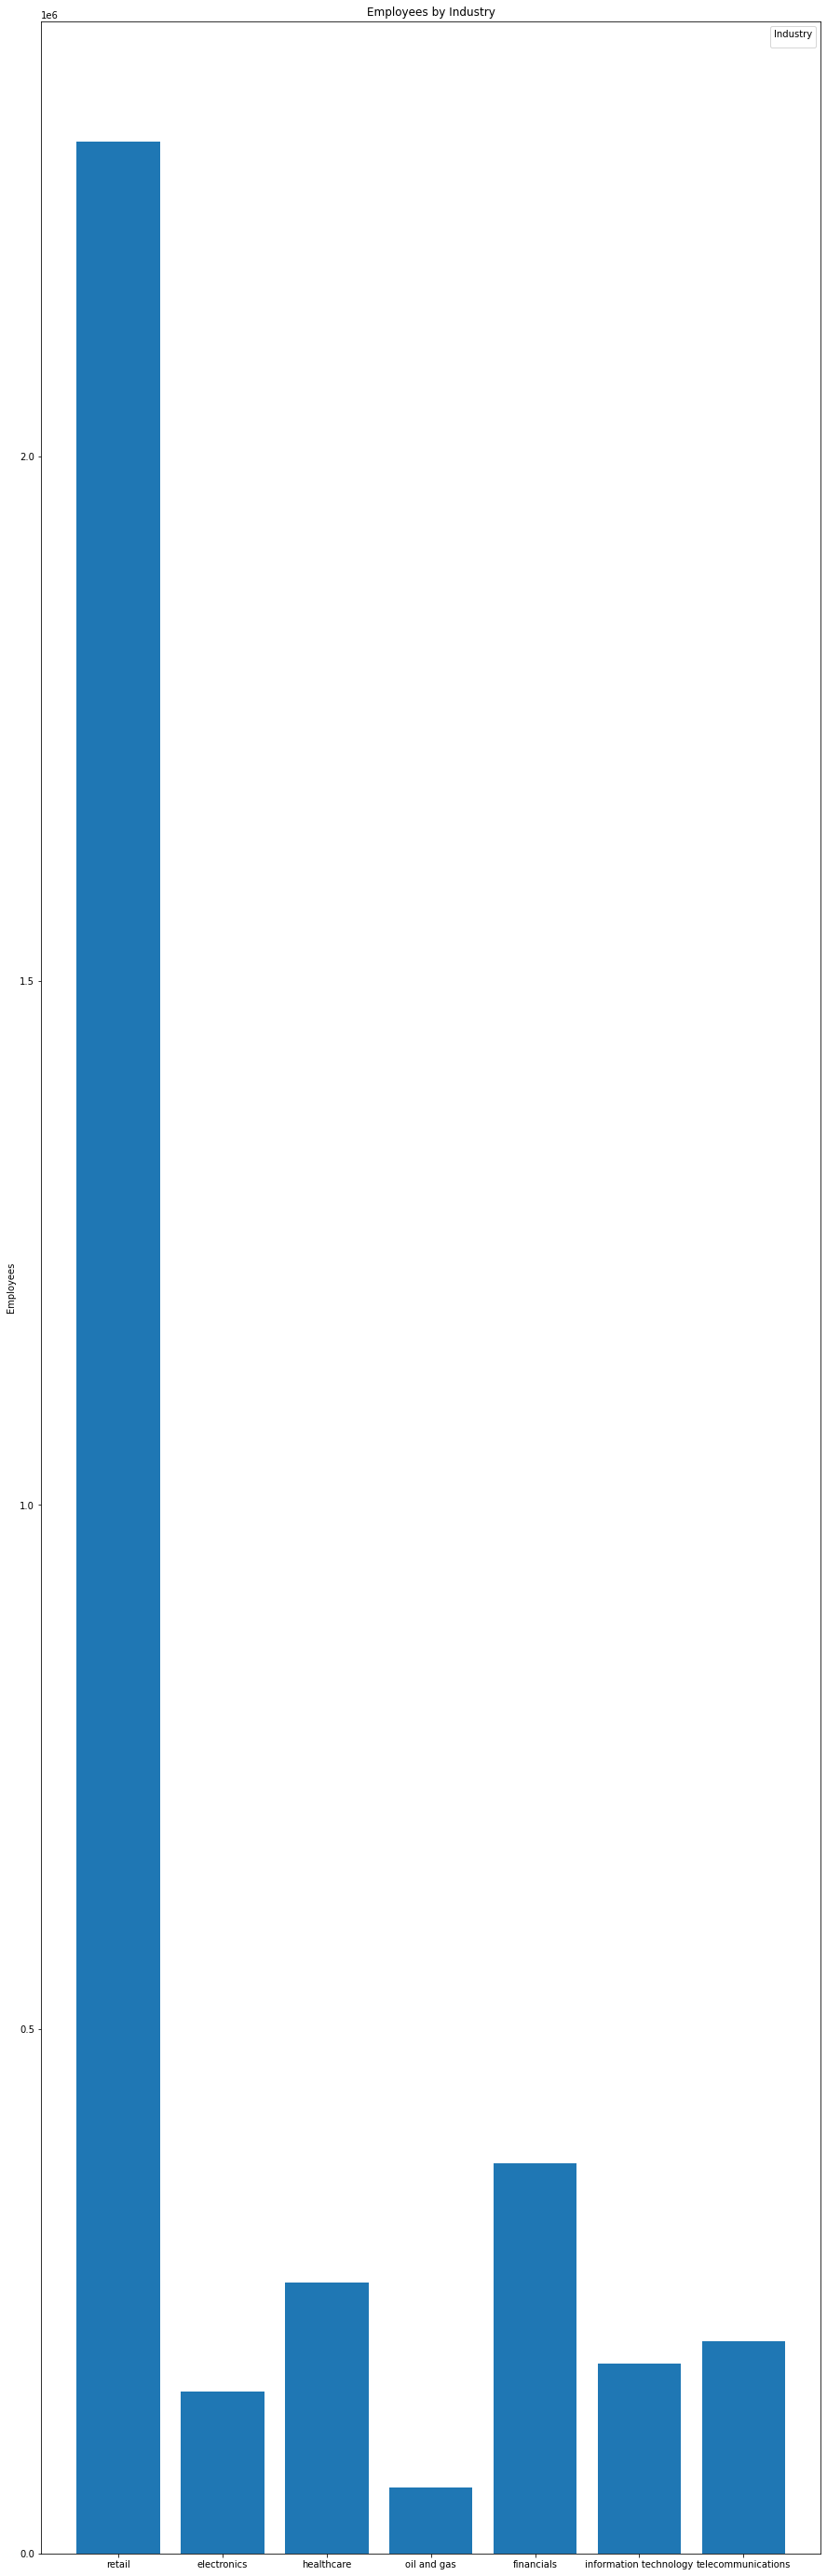

In [61]:
# Plot the data using available libraries.
import matplotlib.pyplot as plt

# Set the fig and ax as subplots.
fig, ax = plt.subplots()

# Set up the axis.
ax.bar(df_found_all["industry"], df_found_all["employees_flat"])

# Set up the labels.
ax.set_ylabel('Employees')
ax.set_title('Employees by Industry')
ax.legend(title='Industry')
plt.rcParams["figure.figsize"] = [5, 50]

# Show the plot.
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


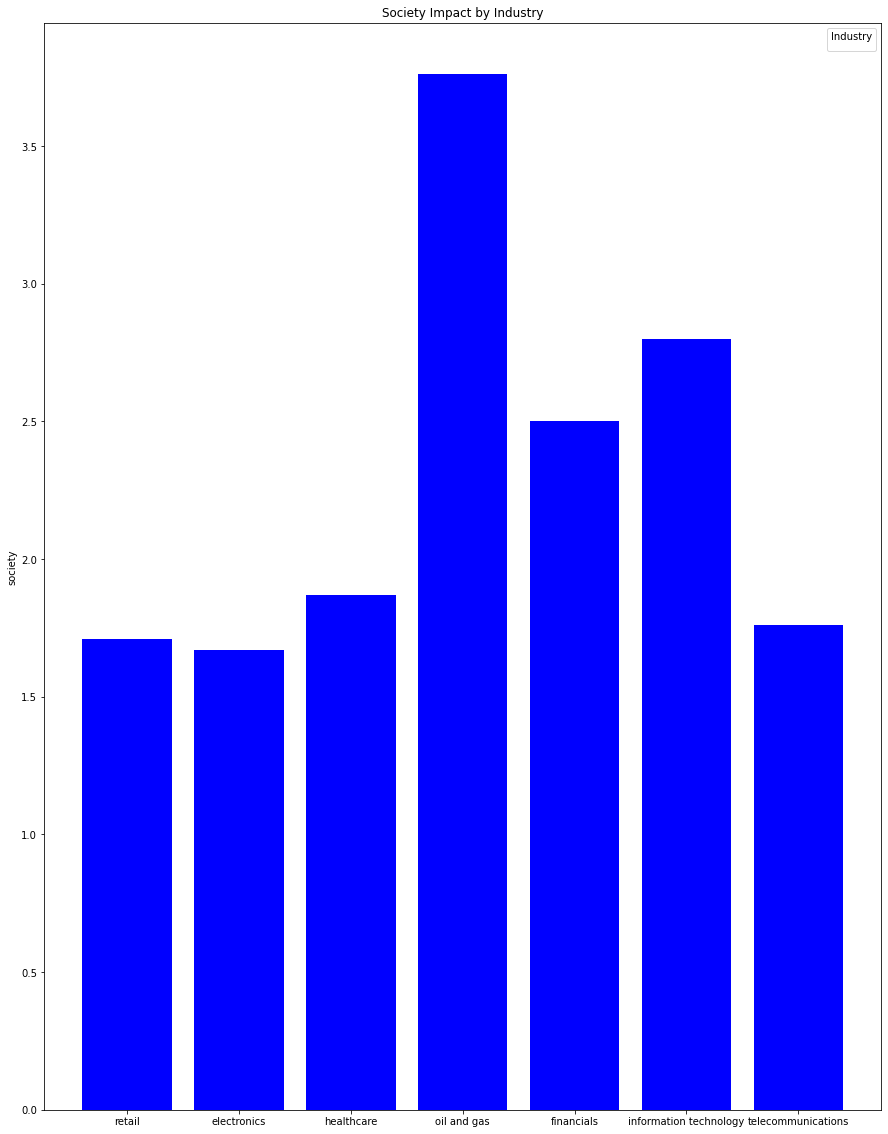

In [64]:
# Plot the impact by industry.
# Set the fig and ax as subplots.
fig, ax = plt.subplots()

# Set up the axis.
ax.bar(df_found_all["industry"], df_found_all["society"], color= ["blue"])

# Set up the labels.
ax.set_ylabel('society')
ax.set_title('Society Impact by Industry')
ax.legend(title='Industry')
plt.rcParams["figure.figsize"] = [15, 30]

# Show the plot.
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


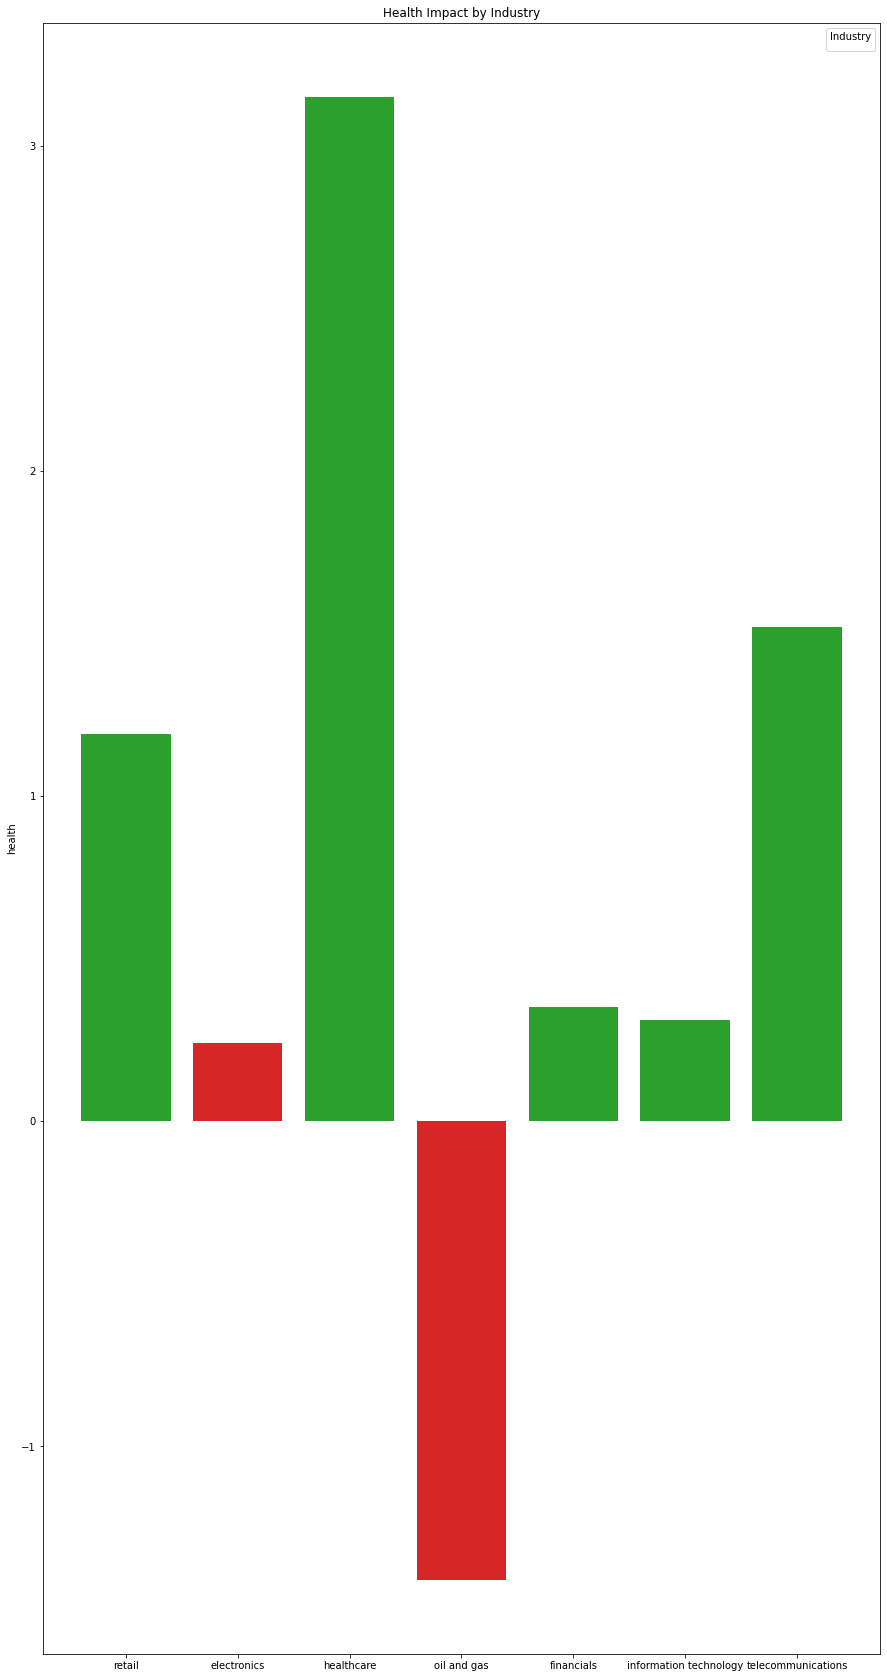

In [74]:
# Plot the impact by industry.
# Set the fig and ax as subplots.
fig, ax = plt.subplots()

# Set up the axis.
bar_colors = ["tab:green", "tab:green", "tab:green", "tab:green", "tab:green", "tab:red", "tab:green"]
ax.bar(df_found_all["industry"], df_found_all["health"], color=bar_colors )

# Set up the labels.
ax.set_ylabel('health')
ax.set_title('Health Impact by Industry')
ax.legend(title='Industry')
plt.rcParams["figure.figsize"] = [15, 30]

# Show the plot.
plt.show()